# Data Diri

nama: Asis Rianto \
email: asisrianto2@gmail.com \
username: [asisrianto](https://www.dicoding.com/users/asisrianto) \

# Import The Libraries

In [1]:
import time 
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# DATA PREPARATION

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/San_Diego_Daily_Weather_Data_2014.csv')
dataset.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587257 entries, 0 to 1587256
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rowID               1587257 non-null  int64  
 1   hpwren_timestamp    1587257 non-null  object 
 2   air_pressure        1587257 non-null  float64
 3   air_temp            1587257 non-null  float64
 4   avg_wind_direction  1586824 non-null  float64
 5   avg_wind_speed      1586824 non-null  float64
 6   max_wind_direction  1586824 non-null  float64
 7   max_wind_speed      1586824 non-null  float64
 8   min_wind_direction  1586824 non-null  float64
 9   min_wind_speed      1586824 non-null  float64
 10  rain_accumulation   1587256 non-null  float64
 11  rain_duration       1587256 non-null  float64
 12  relative_humidity   1587257 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 157.4+ MB


In [5]:
data = dataset[:20000]
data = data[['hpwren_timestamp','air_temp']].copy()
data

,hpwren_timestamp,air_temp
0,2011-09-10 00:00:49,64.76
1,2011-09-10 00:01:49,63.86
2,2011-09-10 00:02:49,64.22
3,2011-09-10 00:03:49,64.40
4,2011-09-10 00:04:49,64.40
...,...,...
19995,2011-09-23 21:33:48,73.94
19996,2011-09-23 21:34:48,73.94
19997,2011-09-23 21:35:48,73.94
19998,2011-09-23 21:36:48,73.94


In [6]:
data['Date'] = pd.to_datetime(data['hpwren_timestamp']).dt.strftime('%Y-%m-%d')
data = data.drop('hpwren_timestamp', axis=1)
data

,air_temp,Date
0,64.76,2011-09-10
1,63.86,2011-09-10
2,64.22,2011-09-10
3,64.40,2011-09-10
4,64.40,2011-09-10
...,...,...
19995,73.94,2011-09-23
19996,73.94,2011-09-23
19997,73.94,2011-09-23
19998,73.94,2011-09-23


In [7]:
data = data.set_index('Date')
data.head()

,air_temp
Date,
2011-09-10,64.76
2011-09-10,63.86
2011-09-10,64.22
2011-09-10,64.40
2011-09-10,64.40


In [8]:
data.describe()

,air_temp
count,20000.000000
mean,70.171637
std,8.248698
min,51.980000
25%,65.480000
50%,71.420000
75%,76.460000
max,91.220000


In [9]:
data.isnull().sum()

air_temp    0
dtype: int64

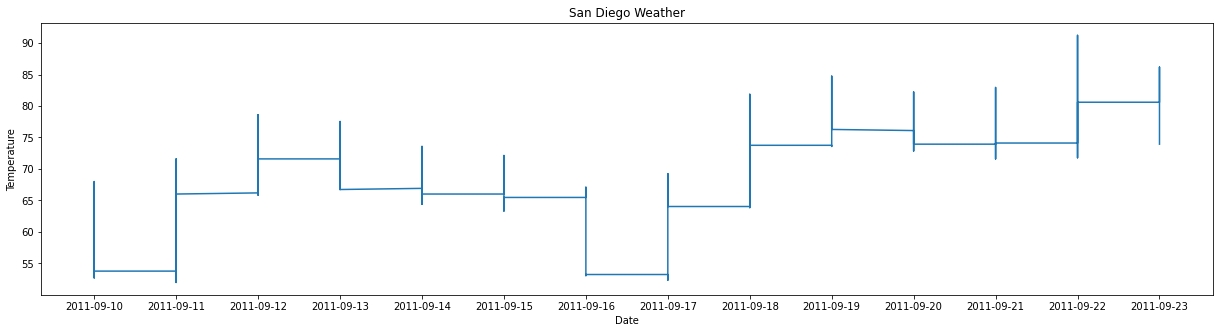

In [10]:
plt.figure(figsize=(21, 5))
plt.plot(data)
plt.title('San Diego Weather')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

# DATA PREPROCESSING

In [11]:
data_train, data_test = train_test_split(data.values, test_size=0.2, shuffle=False)

In [12]:
feature_range=(0,1)

scaler = MinMaxScaler(feature_range=(0,1))
train_scale = scaler.fit_transform(data_train.reshape(-1, 1))
test_scale = scaler.fit_transform(data_test.reshape(-1, 1))

In [13]:
LOOK_BACK = 20
train_set = TimeseriesGenerator(train_scale, train_scale, length=LOOK_BACK, batch_size=20)
test_set = TimeseriesGenerator(test_scale, test_scale, length=LOOK_BACK, batch_size=20)

# MODEL SELECTION

## Architecture

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(LOOK_BACK, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum= 0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=['mae'])

## Callbacks

In [16]:
threshold_mae = (train_scale.max()-train_scale.min()) * (10/100)
threshold_mae

0.1

In [17]:
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      self.model.stop_training = True #stop training if mae < threshold_mae
      print('\nMAE is under 10% of data scale')
callbacks = callbacks()

# MODEL TRAINING

In [18]:
EPOCHS=10

start = time.time()
history = model.fit(train_set, 
                    epochs=EPOCHS, 
                    callbacks=[callbacks],
                    validation_data=test_set,
                    verbose=1)
stop = time.time()

Epoch 1/10
799/799 [==============================] - 29s 27ms/step - loss: 0.0477 - mae: 0.2508 - val_loss: 0.0165 - val_mae: 0.1509
Epoch 2/10
799/799 [==============================] - 22s 27ms/step - loss: 0.0199 - mae: 0.1624 - val_loss: 0.0175 - val_mae: 0.1579
Epoch 3/10
799/799 [==============================] - 19s 24ms/step - loss: 0.0175 - mae: 0.1518 - val_loss: 0.0152 - val_mae: 0.1464
Epoch 4/10
799/799 [==============================] - 21s 26ms/step - loss: 0.0160 - mae: 0.1446 - val_loss: 0.0138 - val_mae: 0.1397
Epoch 5/10
799/799 [==============================] - 21s 26ms/step - loss: 0.0142 - mae: 0.1359 - val_loss: 0.0121 - val_mae: 0.1308
Epoch 6/10
799/799 [==============================] - 19s 24ms/step - loss: 0.0126 - mae: 0.1281 - val_loss: 0.0112 - val_mae: 0.1266
Epoch 7/10
799/799 [==============================] - 19s 24ms/step - loss: 0.0106 - mae: 0.1179 - val_loss: 0.0085 - val_mae: 0.1091
Epoch 8/10
799/799 [==============================] - 21s 26ms

In [19]:
print(f'{stop-start}')

231.8273367881775


Visualization

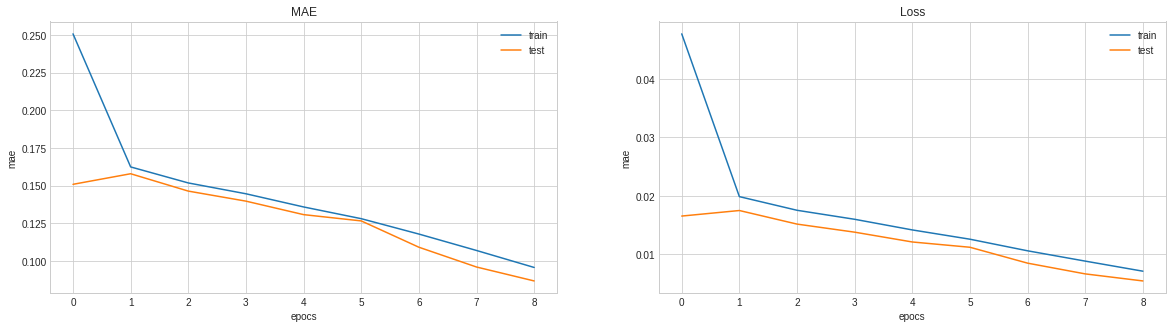

In [20]:
plt.style.use('seaborn-whitegrid')
plt.subplots(1, 2, figsize=[20, 5])

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.xlabel('epocs')
plt.ylabel('mae')
plt.legend(['train','test'],loc=0)

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epocs')
plt.ylabel('mae')
plt.legend(['train','test'],loc=0)


#plt.savefig('proposed_model.png')
plt.show()

# Save The Model

In [21]:
model.save('stock_price_forecasting.h5')